En este notebook la diferencia que hay con respecto al anterior es que estamos haciendo uso del optimizador que usa el artículo de voets, con los parámetros que usan en dicho artículo, aunque manteniendo la misma función de error de los anteriores notebooks, ya que la función de error del artículo de voets está diseñada para una salida sigmoide de la red.

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt
import glob
import shutil
import logging

import random
from random import shuffle

logger = tf.get_logger()
logger.setLevel(logging.ERROR)


print("Num GPUS avadible:",len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUS avadible: 1


In [2]:
classes = ['0', '1', '2', '3', '4']

base_dir=os.path.join( 'prop')

train_dir = os.path.join( 'train8k_2cat')
test_dir = os.path.join('test2k_2cat')


In [3]:

val_dir = test_dir

train_0 = os.path.join(train_dir, '0') 
train_1 = os.path.join(train_dir, '1')
#train_2 = os.path.join(train_dir, '2') 
#train_3 = os.path.join(train_dir, '3')  
#train_4 = os.path.join(train_dir, '4') 

val_0 = os.path.join(val_dir, '0') 
val_1 = os.path.join(val_dir, '1')
#val_2 = os.path.join(val_dir, '2') 
#val_3 = os.path.join(val_dir, '3')  
#val_4 = os.path.join(val_dir, '4')  


#numeros
num_0_tr = len(os.listdir(train_0))
num_1_tr = len(os.listdir(train_1))
#num_2_tr = len(os.listdir(train_2))
#num_3_tr = len(os.listdir(train_3))
#num_4_tr = len(os.listdir(train_4))


num_0_v = len(os.listdir(val_0))
num_1_v = len(os.listdir(val_1))
#num_2_v = len(os.listdir(val_2))
#num_3_v = len(os.listdir(val_3))
#num_4_v = len(os.listdir(val_4))


total_train = num_0_tr + num_1_tr #+ num_2_tr + num_3_tr + num_4_tr
total_val = num_0_v + num_1_v #+ num_2_v + num_3_v + num_4_v
 

In [4]:

def rescale_0_to_1(image):
    """
    Rescale image to [0, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    return tf.image.convert_image_dtype(image, tf.float32)

def rescale_min_1_to_1(image):
    """
    Rescale image to [-1, 1].
    :param image:
        Required. Image tensor.
    :return:
        Scaled image.
    """
    # Image must be casted to float32 first.
    image = tf.cast(image, tf.float32)
    # Rescale image from [0, 255] to [0, 2].
    image = tf.multiply(image, 1. / 127.5)
    # Rescale to [-1, 1].
    return tf.subtract(image, 1.0)

def augment_pre(image):
    
    augmentation=True
    
    BRIGHTNESS_MAX_DELTA = 0.125
    SATURATION_LOWER = 0.5
    SATURATION_UPPER = 1.5
    HUE_MAX_DELTA = 0.2
    CONTRAST_LOWER = 0.5
    CONTRAST_UPPER = 1.5
    
    image = rescale_min_1_to_1(image)

    # Apply data augmentations randomly.
    augmentations = [
        {'fn': tf.image.random_flip_left_right},
        {'fn': tf.image.random_brightness,
         'args': [BRIGHTNESS_MAX_DELTA]},
        {'fn': tf.image.random_saturation,
         'args': [SATURATION_LOWER, SATURATION_UPPER]},
        {'fn': tf.image.random_hue,
         'args': [HUE_MAX_DELTA]},
        {'fn': tf.image.random_contrast,
         'args': [CONTRAST_LOWER, CONTRAST_UPPER]}]

    shuffle(augmentations)

    if augmentation:
        for aug in augmentations:
            if 'args' in aug:
                image = aug['fn'](image, *aug['args'])
            else:
                image = aug['fn'](image)
    return image

In [5]:
img_height=299
img_width=299
batch_size=32


In [6]:
image_gen_train = ImageDataGenerator(
      preprocessing_function=augment_pre
)

train_data_gen = image_gen_train.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     shuffle=True,
                                                     target_size=(img_height,img_width),
                                                     class_mode='binary'
                                                     )

Found 4362 images belonging to 2 classes.


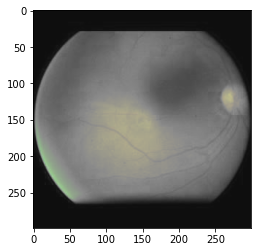

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


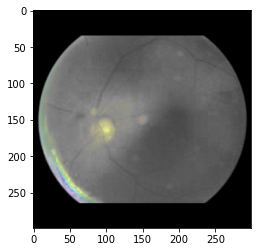

In [7]:

x,y= train_data_gen.next()

for i in range(0,2):
    image = x[i]
    plt.imshow((image+1)/2)
    plt.show()

In [8]:
image_gen_test = ImageDataGenerator(
    preprocessing_function=rescale_min_1_to_1
)

test_data_gen = image_gen_test.flow_from_directory(batch_size=batch_size,
                                                   directory=val_dir,
                                                   target_size=(img_height,img_width),
                                                   class_mode='binary'
                                                  )

Found 1024 images belonging to 2 classes.


In [11]:

with tf.device('/GPU:0'):
    model = tf.keras.models.Sequential([
        tf.keras.applications.InceptionV3(include_top=False, weights='imagenet', pooling='avg'),
        tf.keras.layers.Dense(1,activation='sigmoid')
    ])
    
    



    model.compile(optimizer= tf.keras.optimizers.RMSprop(learning_rate=1e-4,decay=4e-5),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    model.summary()

AttributeError: module 'tensorflow_core._api.v2.nn' has no attribute 'sigmoid_cross_entropy'

In [10]:
with tf.device('/GPU:0'):
    epochs=100
    history = model.fit(
        train_data_gen,
        steps_per_epoch=int(np.ceil(total_train / float(batch_size))),
        epochs=epochs,
        validation_data=test_data_gen,
        validation_steps=int(np.ceil(total_val / float(batch_size)))
    )

Train for 137 steps, validate for 32 steps
Epoch 1/100
137/137 [==============================] - 134s 975ms/step - loss: 0.6776 - accuracy: 0.5816 - val_loss: 0.6708 - val_accuracy: 0.5869
Epoch 2/100
137/137 [==============================] - 115s 838ms/step - loss: 0.6564 - accuracy: 0.6373 - val_loss: 0.6856 - val_accuracy: 0.6055
Epoch 3/100
137/137 [==============================] - 115s 838ms/step - loss: 0.6469 - accuracy: 0.6518 - val_loss: 0.6748 - val_accuracy: 0.6064
Epoch 4/100
137/137 [==============================] - 115s 838ms/step - loss: 0.6405 - accuracy: 0.6678 - val_loss: 0.7252 - val_accuracy: 0.5762
Epoch 5/100
137/137 [==============================] - 115s 839ms/step - loss: 0.6349 - accuracy: 0.6825 - val_loss: 0.7017 - val_accuracy: 0.6094
Epoch 6/100
137/137 [==============================] - 115s 838ms/step - loss: 0.6288 - accuracy: 0.6981 - val_loss: 0.6699 - val_accuracy: 0.6348
Epoch 7/100
137/137 [==============================] - 115s 837ms/step - lo

KeyboardInterrupt: 

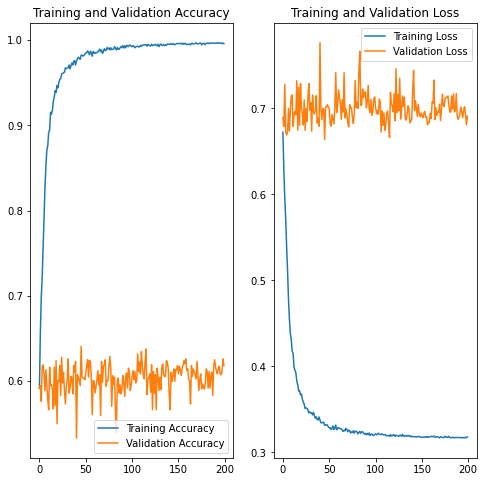

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Mantenemos resultados nefastos para el set de validación, aunque el nuevo optimizador con los nuevos parámetros proporciona un aprendizaje más rápido en el set de entrenamiento.

In [12]:
# Guardar el Modelo
model.save('miniprueba5.h5')

# Recrea exactamente el mismo modelo solo desde el archivo
#new_model = tf.keras.models.load_model('miniprueba2.h5')